In [1]:
import pandas as pd
import json
import sqlite3
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import firebase_admin
from firebase_admin import credentials, initialize_app, storage
import os
import plotly.express as px
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from bs4 import BeautifulSoup

## Ekstrak electricity_access_percent.csv

In [2]:
electricity = pd.read_csv("data_source/electricity_access_percent.csv", skiprows=4)
electricity.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145,NaN,NaN
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138,NaN,NaN
2,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607,NaN,NaN
3,Albania,ALB,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN
4,Andorra,AND,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN


In [3]:
data_electricity_check_missing = electricity.isnull().sum()

print("Mengecek data yang hilang\n")
print(data_electricity_check_missing)


Mengecek data yang hilang

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              264
                 ... 
2014                3
2015                3
2016                3
2017              264
Unnamed: 62       264
Length: 63, dtype: int64


In [4]:
electricity_cleaned = electricity.dropna(axis=1, how='all')

print("Setelah mengatasi data yang hilang\n")
print(electricity_cleaned)


Setelah mengatasi data yang hilang

     Country Name Country Code                           Indicator Name  \
0           Aruba          ABW  Access to electricity (% of population)   
1     Afghanistan          AFG  Access to electricity (% of population)   
2          Angola          AGO  Access to electricity (% of population)   
3         Albania          ALB  Access to electricity (% of population)   
4         Andorra          AND  Access to electricity (% of population)   
..            ...          ...                                      ...   
259        Kosovo          XKX  Access to electricity (% of population)   
260   Yemen, Rep.          YEM  Access to electricity (% of population)   
261  South Africa          ZAF  Access to electricity (% of population)   
262        Zambia          ZMB  Access to electricity (% of population)   
263      Zimbabwe          ZWE  Access to electricity (% of population)   

     Indicator Code        1990        1991        1992        

In [5]:
data_electricity_duplicate = electricity_cleaned.drop_duplicates()

print("Setelah menghapus duplikasi\n")
print(data_electricity_duplicate)


Setelah menghapus duplikasi

     Country Name Country Code                           Indicator Name  \
0           Aruba          ABW  Access to electricity (% of population)   
1     Afghanistan          AFG  Access to electricity (% of population)   
2          Angola          AGO  Access to electricity (% of population)   
3         Albania          ALB  Access to electricity (% of population)   
4         Andorra          AND  Access to electricity (% of population)   
..            ...          ...                                      ...   
259        Kosovo          XKX  Access to electricity (% of population)   
260   Yemen, Rep.          YEM  Access to electricity (% of population)   
261  South Africa          ZAF  Access to electricity (% of population)   
262        Zambia          ZMB  Access to electricity (% of population)   
263      Zimbabwe          ZWE  Access to electricity (% of population)   

     Indicator Code        1990        1991        1992        1993  \

In [6]:
data_electricity_duplicate = data_electricity_duplicate.drop(columns=['Indicator Name', 'Indicator Code'])

data_electricity_duplicate

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Aruba,ABW,88.445351,88.780846,89.115829,89.447754,89.773560,90.090187,90.394585,90.683678,...,92.838821,93.086166,93.354546,93.356292,93.942375,94.255814,94.578262,94.906723,95.238182,95.570145
1,Afghanistan,AFG,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,33.748680,42.400000,44.854885,42.700000,43.222019,69.100000,67.259552,89.500000,71.500000,84.137138
2,Angola,AGO,11.397808,12.579379,13.760440,14.938441,16.110325,17.273031,18.423502,19.558676,...,37.500000,31.268013,32.382469,33.514950,34.600000,35.821964,36.990490,32.000000,42.000000,40.520607
3,Albania,ALB,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
4,Andorra,AND,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,87.694695,88.333473,88.971748,89.606956,90.236053,90.855965,91.463646,92.056030,...,97.244034,97.794670,98.377060,0.000000,99.430435,99.773651,99.942505,99.993134,100.000000,100.000000
260,"Yemen, Rep.",YEM,36.009098,37.441071,44.100000,40.300938,41.723221,43.136330,44.537205,42.600000,...,59.042709,60.386539,61.751400,63.134281,64.532181,65.942101,75.600000,66.100000,70.213905,71.642349
261,South Africa,ZAF,59.337940,60.575081,61.811710,63.045284,64.272736,65.491013,57.600000,67.887794,...,82.000000,81.900000,82.700000,82.900000,84.700000,85.300000,85.400000,86.000000,85.500000,84.200000
262,Zambia,ZMB,13.900000,14.115426,19.200000,15.287503,15.865894,16.435108,17.300000,17.533768,...,18.500000,22.714685,23.235649,22.000000,24.328644,24.894667,25.469702,27.900000,31.100000,27.219337


In [7]:
data_electricity_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  264 non-null    object 
 1   Country Code  264 non-null    object 
 2   1990          251 non-null    float64
 3   1991          251 non-null    float64
 4   1992          251 non-null    float64
 5   1993          251 non-null    float64
 6   1994          252 non-null    float64
 7   1995          255 non-null    float64
 8   1996          256 non-null    float64
 9   1997          256 non-null    float64
 10  1998          256 non-null    float64
 11  1999          256 non-null    float64
 12  2000          257 non-null    float64
 13  2001          258 non-null    float64
 14  2002          259 non-null    float64
 15  2003          259 non-null    float64
 16  2004          260 non-null    float64
 17  2005          260 non-null    float64
 18  2006          260 non-null    

In [8]:
data_electricity_duplicate = pd.melt(data_electricity_duplicate, 
                               id_vars=['Country Name', 'Country Code'], 
                               var_name='Year', 
                               value_name='Electricity')

data_electricity_duplicate


,Country Name,Country Code,Year,Electricity
0,Aruba,ABW,1990,88.445351
1,Afghanistan,AFG,1990,0.010000
2,Angola,AGO,1990,11.397808
3,Albania,ALB,1990,100.000000
4,Andorra,AND,1990,100.000000
...,...,...,...,...
7123,Kosovo,XKX,2016,100.000000
7124,"Yemen, Rep.",YEM,2016,71.642349
7125,South Africa,ZAF,2016,84.200000
7126,Zambia,ZMB,2016,27.219337


In [9]:
# Ubah kolom 'year' menjadi tipe data datetime
data_electricity_duplicate['Year'] = pd.to_datetime(data_electricity_duplicate['Year']).dt.year

data_electricity_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7128 entries, 0 to 7127
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  7128 non-null   object 
 1   Country Code  7128 non-null   object 
 2   Year          7128 non-null   int32  
 3   Electricity   6958 non-null   float64
dtypes: float64(1), int32(1), object(2)
memory usage: 195.0+ KB


In [10]:
data_electricity_duplicate

,Country Name,Country Code,Year,Electricity
0,Aruba,ABW,1990,88.445351
1,Afghanistan,AFG,1990,0.010000
2,Angola,AGO,1990,11.397808
3,Albania,ALB,1990,100.000000
4,Andorra,AND,1990,100.000000
...,...,...,...,...
7123,Kosovo,XKX,2016,100.000000
7124,"Yemen, Rep.",YEM,2016,71.642349
7125,South Africa,ZAF,2016,84.200000
7126,Zambia,ZMB,2016,27.219337


In [11]:
data_electricity_duplicate.to_csv('data_clean/clean_electricity_access_percent.csv', index=False)

## Ekstrak population_data.csv

In [12]:
population_csv = pd.read_csv("data_source/population_data.csv", skiprows=4)
population_csv

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0,NaN
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0,NaN
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0,NaN
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0,NaN
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,...,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0,NaN
260,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,...,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0,NaN
261,South Africa,ZAF,"Population, total",SP.POP.TOTL,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,...,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0,NaN
262,Zambia,ZMB,"Population, total",SP.POP.TOTL,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,...,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0,NaN


In [13]:
population_check_missing = population_csv.isnull().sum()

print("Mengecek data yang hilang\n")
print(population_check_missing)

Mengecek data yang hilang

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960                4
                 ... 
2014                2
2015                2
2016                2
2017                2
Unnamed: 62       264
Length: 63, dtype: int64


In [14]:
population_cleaned = population_csv.dropna(axis=1, how='all')

print("Setelah mengatasi data yang hilang\n")
print(population_cleaned)

Setelah mengatasi data yang hilang

     Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

   

In [15]:
population_duplicate = population_cleaned.drop_duplicates()

print("DataFrame setelah menghapus duplikasi\n")
print(population_duplicate)


DataFrame setelah menghapus duplikasi

     Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   



In [16]:
population_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            260 non-null    flo

In [17]:
population_duplicate = population_duplicate.drop(columns=['Indicator Name', 'Indicator Code'])

population_duplicate

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,5748588.0,5858638.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,20486439.0,21045785.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,3676189.0,3791887.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [18]:
population_duplicate = pd.melt(population_duplicate, 
                               id_vars=['Country Name', 'Country Code'], 
                               var_name='Year', 
                               value_name='Population')

population_duplicate


,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
15307,Kosovo,XKX,2017,1830700.0
15308,"Yemen, Rep.",YEM,2017,28250420.0
15309,South Africa,ZAF,2017,56717156.0
15310,Zambia,ZMB,2017,17094130.0


In [19]:
# Ubah kolom 'year' menjadi tipe data datetime dengan format '%Y'
population_duplicate['Year'] = pd.to_datetime(population_duplicate['Year']).dt.year

In [20]:
population_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  15312 non-null  object 
 1   Country Code  15312 non-null  object 
 2   Year          15312 non-null  int32  
 3   Population    15147 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 418.8+ KB


In [21]:
scaler = MinMaxScaler()

features_to_scale = ['Population']

population_duplicate.loc[:, features_to_scale] = scaler.fit_transform(population_duplicate.loc[:, features_to_scale])

population_duplicate.head()


,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,0.000007
1,Afghanistan,AFG,1960,0.001194
2,Angola,AGO,1960,0.000749
3,Albania,ALB,1960,0.000213
4,Andorra,AND,1960,0.000001


In [22]:
population_duplicate.to_csv('data_clean/clean_population_data.csv', index=False)

## Ektrak gdp_data.csv

In [23]:
gdp = pd.read_csv("data_source/gdp_data.csv", skiprows=4)
gdp.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.498933e+09,2.467704e+09,2.584464e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,1.248694e+10,1.593680e+10,1.793024e+10,2.053654e+10,2.026425e+10,2.061610e+10,1.921556e+10,1.946902e+10,2.081530e+10,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,7.549239e+10,8.252614e+10,1.041158e+11,1.139232e+11,1.249125e+11,1.267302e+11,1.026212e+11,9.533720e+10,1.242094e+11,NaN
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322824e+10,1.138693e+10,1.188368e+10,1.303935e+10,NaN
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09,NaN


In [24]:
gdp_check_missing = gdp.isnull().sum()

print("Mengecek data yang hilang\n")
print(gdp_check_missing)

Mengecek data yang hilang

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              140
                 ... 
2014               17
2015               18
2016               23
2017               30
Unnamed: 62       264
Length: 63, dtype: int64


In [25]:
imputer = SimpleImputer(strategy='constant', fill_value=0)


gdp_imputed = imputer.fit_transform(gdp)

gdp_missing = pd.DataFrame(gdp_imputed, columns=gdp.columns)

print("Setelah mengatasi data yang hilang\n")
print(gdp_missing)

Setelah mengatasi data yang hilang

     Country Name Country Code     Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD   
1     Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD   
2          Angola          AGO  GDP (current US$)  NY.GDP.MKTP.CD   
3         Albania          ALB  GDP (current US$)  NY.GDP.MKTP.CD   
4         Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   
..            ...          ...                ...             ...   
259        Kosovo          XKX  GDP (current US$)  NY.GDP.MKTP.CD   
260   Yemen, Rep.          YEM  GDP (current US$)  NY.GDP.MKTP.CD   
261  South Africa          ZAF  GDP (current US$)  NY.GDP.MKTP.CD   
262        Zambia          ZMB  GDP (current US$)  NY.GDP.MKTP.CD   
263      Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD   

                 1960              1961              1962               1963  \
0                   0                 0                

In [26]:
gdp_duplicate = gdp_missing.drop_duplicates()

# Tampilkan hasil
print("DataFrame setelah menghapus duplikasi\n")
print(gdp_duplicate)

DataFrame setelah menghapus duplikasi

     Country Name Country Code     Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD   
1     Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD   
2          Angola          AGO  GDP (current US$)  NY.GDP.MKTP.CD   
3         Albania          ALB  GDP (current US$)  NY.GDP.MKTP.CD   
4         Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   
..            ...          ...                ...             ...   
259        Kosovo          XKX  GDP (current US$)  NY.GDP.MKTP.CD   
260   Yemen, Rep.          YEM  GDP (current US$)  NY.GDP.MKTP.CD   
261  South Africa          ZAF  GDP (current US$)  NY.GDP.MKTP.CD   
262        Zambia          ZMB  GDP (current US$)  NY.GDP.MKTP.CD   
263      Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD   

                 1960              1961              1962               1963  \
0                   0                 0             

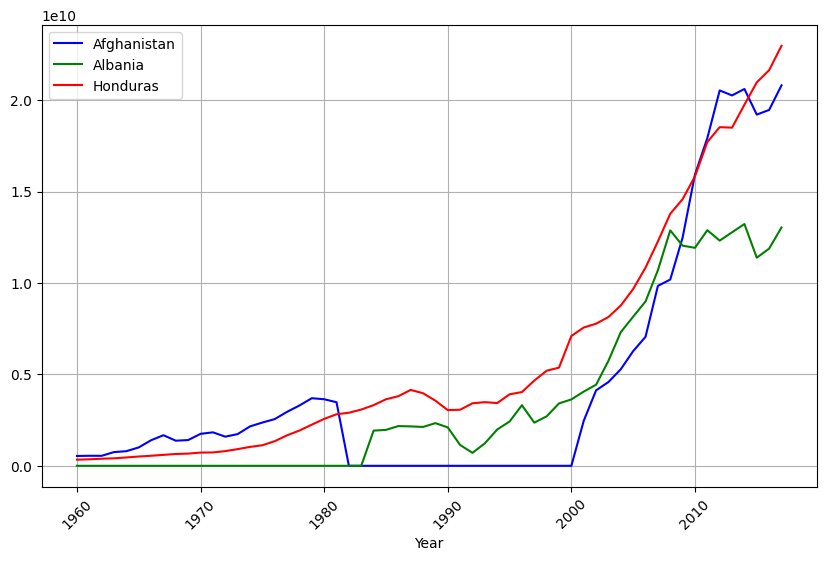

In [27]:
# Membuat plot garis
plt.figure(figsize=(10, 6))

# Mendapatkan nilai GDP untuk Afghanistan, Albania, dan Honduras
afghanistan_gdp = gdp_duplicate.loc[gdp_duplicate['Country Name'] == 'Afghanistan', '1960':'2017'].values.flatten()
albania_gdp = gdp_duplicate.loc[gdp_duplicate['Country Name'] == 'Albania', '1960':'2017'].values.flatten()
honduras_gdp = gdp_duplicate.loc[gdp_duplicate['Country Name'] == 'Honduras', '1960':'2017'].values.flatten()

plt.plot(range(1960, 2018), afghanistan_gdp, label="Afghanistan", color="blue")
plt.plot(range(1960, 2018), albania_gdp, label="Albania", color="green")
plt.plot(range(1960, 2018), honduras_gdp, label="Honduras", color="red")
plt.xlabel("Year")
plt.xticks(range(1960, 2018, 10), rotation=45)
plt.legend()
plt.grid(True)

plt.show()

In [28]:
gdp_duplicate = gdp_duplicate.drop(columns=['Indicator Name', 'Indicator Code', 'Unnamed: 62'])

gdp_duplicate

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,0,0,0,0,0,0,0,0,...,2791960893.85475,2498932960.89385,2467703910.61453,2584463687.15084,0,0,0,0,0,0
1,Afghanistan,AFG,537777811.111111,548888895.555556,546666677.777778,751111191.111111,800000044.444444,1006666637.77778,1399999966.66667,1673333417.77778,...,10190529882.487801,12486943505.7381,15936800636.248699,17930239399.814899,20536542736.729698,20264253973.785801,20616104298.497501,19215562179.0117,19469022207.6852,20815300220.042801
2,Angola,AGO,0,0,0,0,0,0,0,0,...,84178035578.822296,75492385928.333206,82526143645.062302,104115807985.964996,113923162050.110992,124912503781.147995,126730196125.425003,102621215573.455994,95337203468.115601,124209385825.220001
3,Albania,ALB,0,0,0,0,0,0,0,0,...,12881352687.7773,12044212903.816799,11926953258.916,12890867538.530199,12319784787.2987,12776277515.48,13228244357.181299,11386931489.796801,11883682170.823601,13039352743.961599
4,Andorra,AND,0,0,0,0,0,0,0,0,...,4007353156.58415,3660530702.97305,3355695364.23841,3442062830.13622,3164615186.94591,3281585236.32501,3350736367.25488,2811489408.89431,2877311946.90265,3012914131.16971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,0,0,0,0,0,0,0,0,...,5687488208.58356,5653792720.20006,5829933774.83444,6686683347.2338,6500192727.73995,7073420074.34944,7386891336.07536,6439946767.21748,6715486725.66372,7128690556.68244
260,"Yemen, Rep.",YEM,0,0,0,0,0,0,0,0,...,26910851361.755501,25130274124.252399,30906748941.208599,32726417212.348,35401325143.617897,40415235701.987099,43228582065.242699,34602480338.778,18213328571.4286,0
261,South Africa,ZAF,7575248495.0301,7972840543.18914,8497830043.39913,9423211535.769279,10373792524.1495,11334173316.533701,12354752904.9419,13777124457.510799,...,287099991516.900024,297216730668.942017,375298134440.468994,416878162440.887024,396332702639.495972,366829390478.953979,350904575292.317017,317741039197.848022,295762685147.666992,349419343614.088989
262,Zambia,ZMB,713000000.0,696285714.285714,693142857.142857,718714285.714286,839428571.428571,1082857142.85714,1264285714.28571,1368000000.0,...,17910858637.9048,15328342303.9575,20265556273.582001,23460098339.7453,25503370699.2015,28045460442.187599,27150630607.203201,21154394545.895,20954754378.1394,25808666421.555801


In [29]:
gdp_duplicate = pd.melt(gdp_duplicate, 
                               id_vars=['Country Name', 'Country Code'], 
                               var_name='Year', 
                               value_name='gdp')

gdp_duplicate


,Country Name,Country Code,Year,gdp
0,Aruba,ABW,1960,0
1,Afghanistan,AFG,1960,537777811.111111
2,Angola,AGO,1960,0
3,Albania,ALB,1960,0
4,Andorra,AND,1960,0
...,...,...,...,...
15307,Kosovo,XKX,2017,7128690556.68244
15308,"Yemen, Rep.",YEM,2017,0
15309,South Africa,ZAF,2017,349419343614.088989
15310,Zambia,ZMB,2017,25808666421.555801


In [30]:
gdp_duplicate['Year'] = pd.to_datetime(gdp_duplicate['Year']).dt.year

gdp_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  15312 non-null  object
 1   Country Code  15312 non-null  object
 2   Year          15312 non-null  int32 
 3   gdp           15312 non-null  object
dtypes: int32(1), object(3)
memory usage: 418.8+ KB


In [31]:
gdp_duplicate.to_csv('data_clean/clean_gdp_data.csv', index=False)

## Ekstrak data rural_population_percent

In [32]:
rural = pd.read_csv("data_source/rural_population_percent.csv", skiprows=4)
rural.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,Unnamed: 62
0,Aruba,ABW,Rural population (% of total population),SP.RUR.TOTL.ZS,49.224,49.239,49.254,49.270,49.285,49.300,...,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893,NaN
1,Afghanistan,AFG,Rural population (% of total population),SP.RUR.TOTL.ZS,91.779,91.492,91.195,90.890,90.574,90.250,...,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430,NaN
2,Angola,AGO,Rural population (% of total population),SP.RUR.TOTL.ZS,89.565,89.202,88.796,88.376,87.942,87.496,...,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422,NaN
3,Albania,ALB,Rural population (% of total population),SP.RUR.TOTL.ZS,69.295,69.057,68.985,68.914,68.842,68.770,...,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684,NaN
4,Andorra,AND,Rural population (% of total population),SP.RUR.TOTL.ZS,41.550,39.017,36.538,34.128,31.795,29.555,...,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873,NaN


In [33]:
rural_check_missing = rural.isnull().sum()

print("Mengecek data yang hilang\n")
rural_check_missing

Mengecek data yang hilang



Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960                5
                 ... 
2014                4
2015                4
2016                4
2017                4
Unnamed: 62       264
Length: 63, dtype: int64

In [34]:
rural_missing = rural.dropna(axis=1, how='all')
rural_missing = rural.fillna(0)

print("Setelah mengatasi data yang hilang\n")
print(rural_missing)

Setelah mengatasi data yang hilang

     Country Name Country Code                            Indicator Name  \
0           Aruba          ABW  Rural population (% of total population)   
1     Afghanistan          AFG  Rural population (% of total population)   
2          Angola          AGO  Rural population (% of total population)   
3         Albania          ALB  Rural population (% of total population)   
4         Andorra          AND  Rural population (% of total population)   
..            ...          ...                                       ...   
259        Kosovo          XKX  Rural population (% of total population)   
260   Yemen, Rep.          YEM  Rural population (% of total population)   
261  South Africa          ZAF  Rural population (% of total population)   
262        Zambia          ZMB  Rural population (% of total population)   
263      Zimbabwe          ZWE  Rural population (% of total population)   

     Indicator Code    1960    1961    1962    1963

In [35]:
rural_duplicate = rural_missing.drop_duplicates()

print("Setelah menghapus duplikasi\n")
print(rural_duplicate)

Setelah menghapus duplikasi

     Country Name Country Code                            Indicator Name  \
0           Aruba          ABW  Rural population (% of total population)   
1     Afghanistan          AFG  Rural population (% of total population)   
2          Angola          AGO  Rural population (% of total population)   
3         Albania          ALB  Rural population (% of total population)   
4         Andorra          AND  Rural population (% of total population)   
..            ...          ...                                       ...   
259        Kosovo          XKX  Rural population (% of total population)   
260   Yemen, Rep.          YEM  Rural population (% of total population)   
261  South Africa          ZAF  Rural population (% of total population)   
262        Zambia          ZMB  Rural population (% of total population)   
263      Zimbabwe          ZWE  Rural population (% of total population)   

     Indicator Code    1960    1961    1962    1963    196

In [36]:
rural_duplicate = rural_duplicate.drop(columns= ['Indicator Name', 'Indicator Code', 'Unnamed: 62'])

rural_duplicate

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,49.224,49.239,49.254,49.270,49.285,49.300,49.315,49.330,...,56.217,56.579,56.941,57.302,57.636,57.942,58.221,58.472,58.696,58.893
1,Afghanistan,AFG,91.779,91.492,91.195,90.890,90.574,90.250,89.915,89.570,...,76.054,75.687,75.311,74.926,74.532,74.129,73.718,73.297,72.868,72.430
2,Angola,AGO,89.565,89.202,88.796,88.376,87.942,87.496,87.035,86.559,...,61.491,60.701,59.903,59.100,58.301,57.510,56.726,55.950,55.181,54.422
3,Albania,ALB,69.295,69.057,68.985,68.914,68.842,68.770,68.698,68.626,...,50.009,48.924,47.837,46.753,45.670,44.617,43.591,42.593,41.624,40.684
4,Andorra,AND,41.550,39.017,36.538,34.128,31.795,29.555,27.407,25.359,...,11.133,11.648,12.183,12.740,13.292,13.835,14.367,14.885,15.388,15.873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
260,"Yemen, Rep.",YEM,90.900,90.541,90.169,89.784,89.386,88.974,88.549,88.109,...,69.398,68.835,68.268,67.698,67.126,66.550,65.973,65.394,64.813,64.231
261,South Africa,ZAF,53.381,53.207,53.094,52.980,52.866,52.752,52.638,52.524,...,38.846,38.313,37.782,37.254,36.728,36.212,35.702,35.199,34.705,34.218
262,Zambia,ZMB,81.855,81.049,80.215,79.288,77.985,76.628,75.211,73.739,...,62.125,61.701,61.275,60.847,60.413,59.973,59.528,59.078,58.621,58.160


In [37]:
rural_duplicate = pd.melt(rural_duplicate, 
                               id_vars=['Country Name', 'Country Code'], 
                               var_name='Year', 
                               value_name='Rural')

rural_duplicate

,Country Name,Country Code,Year,Rural
0,Aruba,ABW,1960,49.224
1,Afghanistan,AFG,1960,91.779
2,Angola,AGO,1960,89.565
3,Albania,ALB,1960,69.295
4,Andorra,AND,1960,41.550
...,...,...,...,...
15307,Kosovo,XKX,2017,0.000
15308,"Yemen, Rep.",YEM,2017,64.231
15309,South Africa,ZAF,2017,34.218
15310,Zambia,ZMB,2017,58.160


In [38]:
# Ubah kolom 'year' menjadi tipe data datetime dengan format '%Y'
rural_duplicate['Year'] = pd.to_datetime(rural_duplicate['Year']).dt.year
rural_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  15312 non-null  object 
 1   Country Code  15312 non-null  object 
 2   Year          15312 non-null  int32  
 3   Rural         15312 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 418.8+ KB


In [39]:
rural_duplicate.to_csv('data_clean/clean_rural_population_percent.csv', index=False)

## Ekstrak population_data.json

In [40]:
with open('data_source/population_data.json', 'r') as file:
    data_json = json.load(file)

population_json = pd.DataFrame(data_json)

population_json.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


In [41]:
population_json_check_missing = population_json.isnull().sum()

print("Mengecek data yang hilang\n")
print(population_json_check_missing)

Mengecek data yang hilang

Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
1960              4
                 ..
2013              2
2014              2
2015              2
2016              2
2017              2
Length: 62, dtype: int64


In [42]:
population_json_missing = population_json.dropna()


print("Setelah mengatasi data yang hilang\n")
print(population_json_missing)

Setelah mengatasi data yang hilang

     Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

   

In [43]:
population_json_duplicate = population_json_missing.drop_duplicates()


print("Setelah menghapus duplikasi\n")
print(population_json_duplicate)

Setelah menghapus duplikasi

     Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

          

In [44]:
population_json_duplicate = population_json_duplicate.drop(columns= ['Indicator Name', 'Indicator Code'])

population_json_duplicate

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,5748588.0,5858638.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,20486439.0,21045785.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,3676189.0,3791887.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [45]:
population_json_duplicate = pd.melt(population_json_duplicate, 
                               id_vars=['Country Name', 'Country Code'], 
                               var_name='Year', 
                               value_name='Population')

population_json_duplicate

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
14959,Kosovo,XKX,2017,1830700.0
14960,"Yemen, Rep.",YEM,2017,28250420.0
14961,South Africa,ZAF,2017,56717156.0
14962,Zambia,ZMB,2017,17094130.0


In [46]:
population_json_duplicate['Year'] = pd.to_datetime(population_json_duplicate['Year']).dt.year
population_json_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14964 entries, 0 to 14963
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  14964 non-null  object 
 1   Country Code  14964 non-null  object 
 2   Year          14964 non-null  int32  
 3   Population    14964 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 409.3+ KB


In [47]:
scaler = MinMaxScaler()

features_to_scale = ['Population']

population_json_duplicate[features_to_scale] = scaler.fit_transform(population_json_duplicate[features_to_scale])

population_json_duplicate.head()

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,0.000007
1,Afghanistan,AFG,1960,0.001194
2,Angola,AGO,1960,0.000749
3,Albania,ALB,1960,0.000213
4,Andorra,AND,1960,0.000001


In [48]:
population_json_duplicate.to_csv('data_clean/clean_population_data_json.csv', index=False)

## Ektrak population_data.xml

In [49]:
with open("data_source/population_data.xml", "r") as f:
    population_data_xml = f.read()

soup_population_data_xml = BeautifulSoup(population_data_xml, "lxml")

data = []

for record in soup_population_data_xml.find_all("record"):
    record_data = {}

    for field in record.find_all("field"):
        name = field.get("name")
        key = field.get("key")
        value = field.text

        if name == "Country or Area":
            record_data["Country Name"] = value
            record_data["Country Code"] = key
        elif name == "Item":
            record_data["Indicator Name"] = value
            record_data["Indicator Code"] = key
        else:
            record_data[name] = value

    data.append(record_data)

population_xml = pd.DataFrame(data)

population_xml.head()


,Country Name,Country Code,Indicator Name,Indicator Code,Year,Value
0,Aruba,ABW,"Population, total",SP.POP.TOTL,1960,54211
1,Aruba,ABW,"Population, total",SP.POP.TOTL,1961,55438
2,Aruba,ABW,"Population, total",SP.POP.TOTL,1962,56225
3,Aruba,ABW,"Population, total",SP.POP.TOTL,1963,56695
4,Aruba,ABW,"Population, total",SP.POP.TOTL,1964,57032


In [50]:
population_xml_check_missing = population_xml.isnull().sum()

print("Mengecek data yang hilang\n")
print(population_xml_check_missing)

Mengecek data yang hilang

Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
Year              0
Value             0
dtype: int64


In [51]:
population_xml_missing = population_xml.dropna()

print("Setelah mengatasi data yang hilang\n")
print(population_xml_missing)

Setelah mengatasi data yang hilang

      Country Name Country Code     Indicator Name Indicator Code  Year  \
0            Aruba          ABW  Population, total    SP.POP.TOTL  1960   
1            Aruba          ABW  Population, total    SP.POP.TOTL  1961   
2            Aruba          ABW  Population, total    SP.POP.TOTL  1962   
3            Aruba          ABW  Population, total    SP.POP.TOTL  1963   
4            Aruba          ABW  Population, total    SP.POP.TOTL  1964   
...            ...          ...                ...            ...   ...   
15307     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2013   
15308     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2014   
15309     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2015   
15310     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2016   
15311     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2017   

          Value  
0         54211  
1         55438  
2        

In [52]:
population_xml_duplicate = population_xml_missing.drop_duplicates()

print("Setelah menghapus duplikasi\n")
print(population_xml_duplicate)

Setelah menghapus duplikasi

      Country Name Country Code     Indicator Name Indicator Code  Year  \
0            Aruba          ABW  Population, total    SP.POP.TOTL  1960   
1            Aruba          ABW  Population, total    SP.POP.TOTL  1961   
2            Aruba          ABW  Population, total    SP.POP.TOTL  1962   
3            Aruba          ABW  Population, total    SP.POP.TOTL  1963   
4            Aruba          ABW  Population, total    SP.POP.TOTL  1964   
...            ...          ...                ...            ...   ...   
15307     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2013   
15308     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2014   
15309     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2015   
15310     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2016   
15311     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2017   

          Value  
0         54211  
1         55438  
2         56225 

In [53]:
population_xml_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country Name    15312 non-null  object
 1   Country Code    15312 non-null  object
 2   Indicator Name  15312 non-null  object
 3   Indicator Code  15312 non-null  object
 4   Year            15312 non-null  object
 5   Value           15312 non-null  object
dtypes: object(6)
memory usage: 717.9+ KB


In [54]:
population_xml_duplicate['Year'] = pd.to_datetime(population_xml_duplicate['Year']).dt.year
population_xml_duplicate['Value']= pd.to_numeric(population_xml_duplicate['Value'])

population_xml_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15312 entries, 0 to 15311
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    15312 non-null  object 
 1   Country Code    15312 non-null  object 
 2   Indicator Name  15312 non-null  object 
 3   Indicator Code  15312 non-null  object 
 4   Year            15312 non-null  int32  
 5   Value           15147 non-null  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 658.1+ KB


In [55]:
population_xml_duplicate.drop(columns=['Indicator Name', 'Indicator Code'], inplace=True)

In [56]:
population_xml_duplicate.rename(columns={'Country_or_Area': 'Country Name'}, inplace=True)
population_xml_duplicate.rename(columns={'Value': 'Population'}, inplace=True)

population_xml_duplicate

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Aruba,ABW,1961,55438.0
2,Aruba,ABW,1962,56225.0
3,Aruba,ABW,1963,56695.0
4,Aruba,ABW,1964,57032.0
...,...,...,...,...
15307,Zimbabwe,ZWE,2013,15054506.0
15308,Zimbabwe,ZWE,2014,15411675.0
15309,Zimbabwe,ZWE,2015,15777451.0
15310,Zimbabwe,ZWE,2016,16150362.0


In [57]:
scaler = MinMaxScaler()

features_to_scale = ['Population']

population_xml_duplicate[features_to_scale] = scaler.fit_transform(population_xml_duplicate[features_to_scale])

population_xml_duplicate.head()

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,0.000007
1,Aruba,ABW,1961,0.000007
2,Aruba,ABW,1962,0.000007
3,Aruba,ABW,1963,0.000007
4,Aruba,ABW,1964,0.000007


In [58]:
population_xml_duplicate.to_csv('data_clean/clean_population_data_xml.csv', index=False)

## Ekstrak population_data.db

In [59]:
conn = sqlite3.connect('data_source/population_data.db')

cursor = conn.cursor()

cursor.execute("SELECT * FROM population_data")

result = cursor.fetchall()

population_data_db = pd.DataFrame(result, columns=[col[0] for col in cursor.description])

conn.close()

print(population_data_db.head())

   index Country_Name Country_Code     Indicator_Name Indicator_Code  \
0      0        Aruba          ABW  Population, total    SP.POP.TOTL   
1      1  Afghanistan          AFG  Population, total    SP.POP.TOTL   
2      2       Angola          AGO  Population, total    SP.POP.TOTL   
3      3      Albania          ALB  Population, total    SP.POP.TOTL   
4      4      Andorra          AND  Population, total    SP.POP.TOTL   

        1960       1961       1962       1963       1964  ...        2008  \
0    54211.0    55438.0    56225.0    56695.0    57032.0  ...    101353.0   
1  8996351.0  9166764.0  9345868.0  9533954.0  9731361.0  ...  27294031.0   
2  5643182.0  5753024.0  5866061.0  5980417.0  6093321.0  ...  21759420.0   
3  1608800.0  1659800.0  1711319.0  1762621.0  1814135.0  ...   2947314.0   
4    13411.0    14375.0    15370.0    16412.0    17469.0  ...     83861.0   

         2009        2010        2011        2012        2013        2014  \
0    101453.0    101669.0  

In [60]:
population_data_db_check_missing = population_data_db.isnull().sum()

print("Mengecek data yang hilang\n")
population_data_db_check_missing

Mengecek data yang hilang



index             0
Country_Name      0
Country_Code      0
Indicator_Name    0
Indicator_Code    0
                 ..
2013              2
2014              2
2015              2
2016              2
2017              2
Length: 63, dtype: int64

In [61]:
population_data_db_missing = population_data_db.dropna()

print("Setelah mengatasi data yang hilang\n")
print(population_data_db_missing.head())

Setelah mengatasi data yang hilang

   index Country_Name Country_Code     Indicator_Name Indicator_Code  \
0      0        Aruba          ABW  Population, total    SP.POP.TOTL   
1      1  Afghanistan          AFG  Population, total    SP.POP.TOTL   
2      2       Angola          AGO  Population, total    SP.POP.TOTL   
3      3      Albania          ALB  Population, total    SP.POP.TOTL   
4      4      Andorra          AND  Population, total    SP.POP.TOTL   

        1960       1961       1962       1963       1964  ...        2008  \
0    54211.0    55438.0    56225.0    56695.0    57032.0  ...    101353.0   
1  8996351.0  9166764.0  9345868.0  9533954.0  9731361.0  ...  27294031.0   
2  5643182.0  5753024.0  5866061.0  5980417.0  6093321.0  ...  21759420.0   
3  1608800.0  1659800.0  1711319.0  1762621.0  1814135.0  ...   2947314.0   
4    13411.0    14375.0    15370.0    16412.0    17469.0  ...     83861.0   

         2009        2010        2011        2012        2013       

In [62]:
population_data_db_duplicate = population_data_db_missing.drop_duplicates()

print("Setelah menghapus duplikasi\n")
print(population_data_db_duplicate.head())

Setelah menghapus duplikasi

   index Country_Name Country_Code     Indicator_Name Indicator_Code  \
0      0        Aruba          ABW  Population, total    SP.POP.TOTL   
1      1  Afghanistan          AFG  Population, total    SP.POP.TOTL   
2      2       Angola          AGO  Population, total    SP.POP.TOTL   
3      3      Albania          ALB  Population, total    SP.POP.TOTL   
4      4      Andorra          AND  Population, total    SP.POP.TOTL   

        1960       1961       1962       1963       1964  ...        2008  \
0    54211.0    55438.0    56225.0    56695.0    57032.0  ...    101353.0   
1  8996351.0  9166764.0  9345868.0  9533954.0  9731361.0  ...  27294031.0   
2  5643182.0  5753024.0  5866061.0  5980417.0  6093321.0  ...  21759420.0   
3  1608800.0  1659800.0  1711319.0  1762621.0  1814135.0  ...   2947314.0   
4    13411.0    14375.0    15370.0    16412.0    17469.0  ...     83861.0   

         2009        2010        2011        2012        2013        2014  

In [63]:
population_data_db_duplicate.drop(columns=['index', 'Indicator_Name', 'Indicator_Code'], inplace=True)

population_data_db_duplicate.head()

,Country_Name,Country_Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


In [64]:
population_data_db_duplicate.rename(columns={'Country_Name': 'Country Name', 'Country_Code': 'Country Code'}, inplace=True)

In [65]:
population_data_db_duplicate = pd.melt(population_data_db_duplicate, 
                               id_vars=['Country Name', 'Country Code'], 
                               var_name='Year', 
                               value_name='Population')

population_data_db_duplicate


,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
14959,Kosovo,XKX,2017,1830700.0
14960,"Yemen, Rep.",YEM,2017,28250420.0
14961,South Africa,ZAF,2017,56717156.0
14962,Zambia,ZMB,2017,17094130.0


In [66]:
population_data_db_duplicate['Year'] = pd.to_datetime(population_data_db_duplicate['Year']).dt.year

population_data_db_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14964 entries, 0 to 14963
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  14964 non-null  object 
 1   Country Code  14964 non-null  object 
 2   Year          14964 non-null  int32  
 3   Population    14964 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 409.3+ KB


In [67]:
scaler = MinMaxScaler()

features_to_scale = ['Population']

population_data_db_duplicate[features_to_scale] = scaler.fit_transform(population_data_db_duplicate[features_to_scale])

population_data_db_duplicate.head()

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,0.000007
1,Afghanistan,AFG,1960,0.001194
2,Angola,AGO,1960,0.000749
3,Albania,ALB,1960,0.000213
4,Andorra,AND,1960,0.000001


In [68]:
population_data_db_duplicate.to_csv('data_clean/clean_population_data_db.csv', index=False)

## Ekstrak data dari api

In [69]:
url = "https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json&per_page=30000"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()[1]  # Memilih bagian data dari JSON
    data_world_bank = pd.DataFrame(data)
    columns = ['country.value', 'countryiso3code', 'indicator.id', 'indicator.value', 'date', 'value']
    data_world_bank = pd.json_normalize(data)[columns]
    data_world_bank.columns = ['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name', 'Year', 'Population']

else:
    print("Error:", response.status_code)
    
data_world_bank.head()

,Country Name,Country Code,Indicator Code,Indicator Name,Year,Population
0,Africa Eastern and Southern,AFE,SP.POP.TOTL,"Population, total",2023,NaN
1,Africa Eastern and Southern,AFE,SP.POP.TOTL,"Population, total",2022,720859132.0
2,Africa Eastern and Southern,AFE,SP.POP.TOTL,"Population, total",2021,702977106.0
3,Africa Eastern and Southern,AFE,SP.POP.TOTL,"Population, total",2020,685112979.0
4,Africa Eastern and Southern,AFE,SP.POP.TOTL,"Population, total",2019,667242986.0


In [70]:
data_world_bank = data_world_bank.drop(columns=['Indicator Code', 'Indicator Name'])

data_world_bank

,Country Name,Country Code,Year,Population
0,Africa Eastern and Southern,AFE,2023,NaN
1,Africa Eastern and Southern,AFE,2022,720859132.0
2,Africa Eastern and Southern,AFE,2021,702977106.0
3,Africa Eastern and Southern,AFE,2020,685112979.0
4,Africa Eastern and Southern,AFE,2019,667242986.0
...,...,...,...,...
17019,Zimbabwe,ZWE,1964,4310332.0
17020,Zimbabwe,ZWE,1963,4177931.0
17021,Zimbabwe,ZWE,1962,4049778.0
17022,Zimbabwe,ZWE,1961,3925952.0


In [71]:
data_world_bank_check_missing = data_world_bank.isnull().sum()

print('Mengecek data yang hilang\n')
print(data_world_bank_check_missing)

Mengecek data yang hilang

Country Name      0
Country Code      0
Year              0
Population      359
dtype: int64


In [72]:
data_world_bank_missing = data_world_bank.dropna()

print('Setelah mengatasi data yang hilang\n')
print(data_world_bank_missing)

Setelah mengatasi data yang hilang

                      Country Name Country Code  Year   Population
1      Africa Eastern and Southern          AFE  2022  720859132.0
2      Africa Eastern and Southern          AFE  2021  702977106.0
3      Africa Eastern and Southern          AFE  2020  685112979.0
4      Africa Eastern and Southern          AFE  2019  667242986.0
5      Africa Eastern and Southern          AFE  2018  649757148.0
...                            ...          ...   ...          ...
17019                     Zimbabwe          ZWE  1964    4310332.0
17020                     Zimbabwe          ZWE  1963    4177931.0
17021                     Zimbabwe          ZWE  1962    4049778.0
17022                     Zimbabwe          ZWE  1961    3925952.0
17023                     Zimbabwe          ZWE  1960    3806310.0

[16665 rows x 4 columns]


In [73]:
# Mengambil hanya kolom yang tidak memiliki tipe data dict
data_word_bank_duplicate = data_world_bank_missing.drop_duplicates()

print('Setelah menghapus duplikasi\n')
print(data_word_bank_duplicate.head())


Setelah menghapus duplikasi

                  Country Name Country Code  Year   Population
1  Africa Eastern and Southern          AFE  2022  720859132.0
2  Africa Eastern and Southern          AFE  2021  702977106.0
3  Africa Eastern and Southern          AFE  2020  685112979.0
4  Africa Eastern and Southern          AFE  2019  667242986.0
5  Africa Eastern and Southern          AFE  2018  649757148.0


In [74]:
data_word_bank_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16665 entries, 1 to 17023
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  16665 non-null  object 
 1   Country Code  16665 non-null  object 
 2   Year          16665 non-null  object 
 3   Population    16665 non-null  float64
dtypes: float64(1), object(3)
memory usage: 651.0+ KB


In [75]:
data_word_bank_duplicate['Year'] = pd.to_datetime(data_word_bank_duplicate['Year']).dt.year
data_word_bank_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16665 entries, 1 to 17023
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  16665 non-null  object 
 1   Country Code  16665 non-null  object 
 2   Year          16665 non-null  int32  
 3   Population    16665 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 585.9+ KB


In [76]:
data_word_bank_duplicate.to_csv('data_clean/clean_data_world_bank.csv')

## Ekstrak data mystery

In [77]:
mystery = pd.read_csv('data_source/mystery.csv', encoding='utf-16')

mystery.head()


,Unnamed: 0,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,0,Aruba,ABW,"Population, total",SP.POP.TOTL,54211.0,55438.0,56225.0,56695.0,57032.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,1,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,2,Angola,AGO,"Population, total",SP.POP.TOTL,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,3,Albania,ALB,"Population, total",SP.POP.TOTL,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,4,Andorra,AND,"Population, total",SP.POP.TOTL,13411.0,14375.0,15370.0,16412.0,17469.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0


In [78]:
mystery_check_missing = mystery.isnull().sum()

print('Mengecek data yang hilang\n')
print(mystery_check_missing)

Mengecek data yang hilang

Unnamed: 0        0
Country Name      0
Country Code      0
Indicator Name    0
Indicator Code    0
                 ..
2013              2
2014              2
2015              2
2016              2
2017              2
Length: 63, dtype: int64


In [79]:
mystery_missing = mystery.dropna()

print('Setelah mengatasi data yang hilang\n')
print(mystery_missing)

Setelah mengatasi data yang hilang

     Unnamed: 0  Country Name Country Code     Indicator Name Indicator Code  \
0             0         Aruba          ABW  Population, total    SP.POP.TOTL   
1             1   Afghanistan          AFG  Population, total    SP.POP.TOTL   
2             2        Angola          AGO  Population, total    SP.POP.TOTL   
3             3       Albania          ALB  Population, total    SP.POP.TOTL   
4             4       Andorra          AND  Population, total    SP.POP.TOTL   
..          ...           ...          ...                ...            ...   
259         259        Kosovo          XKX  Population, total    SP.POP.TOTL   
260         260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   
261         261  South Africa          ZAF  Population, total    SP.POP.TOTL   
262         262        Zambia          ZMB  Population, total    SP.POP.TOTL   
263         263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   

   

In [80]:
mystery_duplicate = mystery_missing.drop_duplicates()

print('DataFrame setelah mengatasi duplikasi\n')
print(mystery_duplicate)


DataFrame setelah mengatasi duplikasi

     Unnamed: 0  Country Name Country Code     Indicator Name Indicator Code  \
0             0         Aruba          ABW  Population, total    SP.POP.TOTL   
1             1   Afghanistan          AFG  Population, total    SP.POP.TOTL   
2             2        Angola          AGO  Population, total    SP.POP.TOTL   
3             3       Albania          ALB  Population, total    SP.POP.TOTL   
4             4       Andorra          AND  Population, total    SP.POP.TOTL   
..          ...           ...          ...                ...            ...   
259         259        Kosovo          XKX  Population, total    SP.POP.TOTL   
260         260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   
261         261  South Africa          ZAF  Population, total    SP.POP.TOTL   
262         262        Zambia          ZMB  Population, total    SP.POP.TOTL   
263         263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   



In [81]:
mystery_duplicate = mystery_duplicate.drop(columns= ['Indicator Name', 'Indicator Code', 'Unnamed: 0'])

mystery_duplicate

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,54211.0,55438.0,56225.0,56695.0,57032.0,57360.0,57715.0,58055.0,...,101353.0,101453.0,101669.0,102053.0,102577.0,103187.0,103795.0,104341.0,104822.0,105264.0
1,Afghanistan,AFG,8996351.0,9166764.0,9345868.0,9533954.0,9731361.0,9938414.0,10152331.0,10372630.0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,35530081.0
2,Angola,AGO,5643182.0,5753024.0,5866061.0,5980417.0,6093321.0,6203299.0,6309770.0,6414995.0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,29784193.0
3,Albania,ALB,1608800.0,1659800.0,1711319.0,1762621.0,1814135.0,1864791.0,1914573.0,1965598.0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,2873457.0
4,Andorra,AND,13411.0,14375.0,15370.0,16412.0,17469.0,18549.0,19647.0,20758.0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,76965.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Kosovo,XKX,947000.0,966000.0,994000.0,1022000.0,1050000.0,1078000.0,1106000.0,1135000.0,...,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0,1830700.0
260,"Yemen, Rep.",YEM,5172135.0,5260501.0,5351799.0,5446063.0,5543339.0,5643643.0,5748588.0,5858638.0,...,22356391.0,22974929.0,23606779.0,24252206.0,24909969.0,25576322.0,26246327.0,26916207.0,27584213.0,28250420.0
261,South Africa,ZAF,17456855.0,17920673.0,18401608.0,18899275.0,19412975.0,19942303.0,20486439.0,21045785.0,...,50412129.0,50970818.0,51584663.0,52263516.0,52998213.0,53767396.0,54539571.0,55291225.0,56015473.0,56717156.0
262,Zambia,ZMB,3044846.0,3140264.0,3240587.0,3345145.0,3452942.0,3563407.0,3676189.0,3791887.0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,17094130.0


In [82]:
mystery_duplicate = pd.melt(mystery_duplicate, 
                               id_vars=['Country Name', 'Country Code'], 
                               var_name='Year', 
                               value_name='Population')

mystery_duplicate

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
14959,Kosovo,XKX,2017,1830700.0
14960,"Yemen, Rep.",YEM,2017,28250420.0
14961,South Africa,ZAF,2017,56717156.0
14962,Zambia,ZMB,2017,17094130.0


In [83]:
mystery_duplicate['Year'] = pd.to_datetime(mystery_duplicate['Year']).dt.year

mystery_duplicate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14964 entries, 0 to 14963
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  14964 non-null  object 
 1   Country Code  14964 non-null  object 
 2   Year          14964 non-null  int32  
 3   Population    14964 non-null  float64
dtypes: float64(1), int32(1), object(2)
memory usage: 409.3+ KB


In [84]:
mystery_duplicate.to_csv('data_clean/clean_mystery_data.csv', index=False)

## Ekstrak project_data

In [85]:
project = pd.read_csv('data_source/projects_data.csv', low_memory=False)
project.head(10)

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,envassesmentcategorycode,supplementprojectflg,productlinetype,projectstatusdisplay,...,mjtheme3name,mjtheme4name,mjtheme5name,location,GeoLocID,GeoLocName,Latitude,Longitude,Country,Unnamed: 56
0,P162228,Other,World;World,RE,Investment Project Financing,IN,C,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P163962,Africa,Democratic Republic of the Congo;Democratic Re...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P167672,South Asia,People's Republic of Bangladesh;People's Repub...,PE,Investment Project Financing,IN,NaN,Y,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,P158768,South Asia,Islamic Republic of Afghanistan;Islamic Repu...,PE,Investment Project Financing,IN,A,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,P161364,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...,0002327546;0002328925;0002565340;0002565343;00...,Ogun State;Niger State;Abia State;Edo;Kebbi St...,7;10;5.41667;6.5;11.5;8,3.58333;6;7.5;6;4;10.5,NG;NG;NG;NG;NG;NG,NaN
5,P161483,Middle East and North Africa,Republic of Tunisia;Republic of Tunisia,PE,Development Policy Lending,AD,NaN,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,P161885,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,P162069,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,B,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,P163540,Africa,Federal Republic of Nigeria;Federal Republic o...,PE,Investment Project Financing,IN,C,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,P163576,Middle East and North Africa,Lebanese Republic;Lebanese Republic,PE,Program-for-Results,PR,NaN,N,L,Active,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
columns_drop = ['projectdoc ', 'majorsector_percent ', 'sector1', 'sector2', 
                'sector3', 'sector4', 'sector5', 'sector', 'mjsector1', 
                'mjsector2', 'mjsector3', 'mjsector4', 'mjsector5', 
                'mjsector', 'theme1', 'theme2', 'theme3', 'theme4', 
                'theme5', 'theme ', 'goal', 'financier', 'mjtheme1name', 
                'mjtheme2name', 'mjtheme3name', 'mjtheme4name', 
                'mjtheme5name', 'location', 'GeoLocID', 'GeoLocName', 
                'Latitude', 'Longitude', 'Country', 'envassesmentcategorycode',
                'supplementprojectflg', 'borrower', 'impagency', 'Unnamed: 56']

project.drop(columns=columns_drop, axis=1, inplace=True)


In [87]:
project['countryname'] = project['countryname'].str.split(';').str[0]

project['boardapprovaldate'] = pd.to_datetime(project['boardapprovaldate'])
project['closingdate'] = pd.to_datetime(project['closingdate'])

project[['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt']] = project[['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt']].apply(pd.to_numeric, errors='coerce')
project[['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt']] = project[['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt']].replace({',' : ''}, regex=True)

project['boardapprovaldate'] = pd.to_datetime(project['boardapprovaldate'])
project['boardapprovaldate'] = project['boardapprovaldate'].dt.year
project['boardapprovaldate'] = project['boardapprovaldate'].fillna(0).astype(int)

print(project.info())
project.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   id                    18248 non-null  object             
 1   regionname            18248 non-null  object             
 2   countryname           18248 non-null  object             
 3   prodline              18248 non-null  object             
 4   lendinginstr          18002 non-null  object             
 5   lendinginstrtype      18002 non-null  object             
 6   productlinetype       18248 non-null  object             
 7   projectstatusdisplay  18244 non-null  object             
 8   status                18244 non-null  object             
 9   project_name          18248 non-null  object             
 10  boardapprovaldate     18248 non-null  int32              
 11  board_approval_month  16744 non-null  object             
 12  clos

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,productlinetype,projectstatusdisplay,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,url
0,P162228,Other,World,RE,Investment Project Financing,IN,L,Active,Active,Creating a Trade in Value-Added Database for ...,2018,June,NaT,500000.0,0,0,0,500000,http://projects.worldbank.org/P162228?lang=en
1,P163962,Africa,Democratic Republic of the Congo,PE,Investment Project Financing,IN,L,Active,Active,Productive Inclusion Project,2018,June,2023-12-31 00:00:00+00:00,200000000.0,0,200000000,200000000,0,http://projects.worldbank.org/P163962?lang=en
2,P167672,South Asia,People's Republic of Bangladesh,PE,Investment Project Financing,IN,L,Active,Active,Additional Financing for Health Sector Support...,2018,June,NaT,50000000.0,0,58330000,58330000,0,http://projects.worldbank.org/P167672?lang=en
3,P158768,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,L,Active,Active,Public-Private Partnerships and Public Investm...,2018,June,2023-06-28 00:00:00+00:00,50000000.0,0,20000000,20000000,0,http://projects.worldbank.org/P158768?lang=en
4,P161364,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,L,Active,Active,Nigeria For Women Project,2018,June,2023-05-31 00:00:00+00:00,100000000.0,0,100000000,100000000,0,http://projects.worldbank.org/P161364?lang=en
5,P161483,Middle East and North Africa,Republic of Tunisia,PE,Development Policy Lending,AD,L,Active,Active,Tunisia Investment; Competitiveness and Inclusion,2018,June,2019-12-31 00:00:00+00:00,500000000.0,500000000,0,500000000,0,http://projects.worldbank.org/P161483?lang=en
6,P161885,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,L,Active,Active,Nigeria Electrification Project,2018,June,2023-10-31 00:00:00+00:00,765000000.0,0,350000000,350000000,0,http://projects.worldbank.org/P161885?lang=en
7,P162069,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,L,Active,Active,Nigeria- Accelerating Nutrition Results,2018,June,2023-12-31 00:00:00+00:00,232000000.0,0,225000000,225000000,0,http://projects.worldbank.org/P162069?lang=en
8,P163540,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,L,Active,Active,Fiscal Governance and Institutions Project,2018,June,2022-12-31 00:00:00+00:00,125000000.0,0,125000000,125000000,0,http://projects.worldbank.org/P163540?lang=en
9,P163576,Middle East and North Africa,Lebanese Republic,PE,Program-for-Results,PR,L,Active,Active,Creating Economic Opportunities - Lebanon Nati...,2018,June,2023-12-31 00:00:00+00:00,695000000.0,329900000,0,329900000,0,http://projects.worldbank.org/P163576?lang=en


In [88]:
project_check_missing = project.isnull().sum()

print('Mengecek data yang hilang\n')
print(project_check_missing)

Mengecek data yang hilang

id                         0
regionname                 0
countryname                0
prodline                   0
lendinginstr             246
lendinginstrtype         246
productlinetype            0
projectstatusdisplay       4
status                     4
project_name               0
boardapprovaldate          0
board_approval_month    1504
closingdate             3349
lendprojectcost          125
ibrdcommamt                0
idacommamt                 0
totalamt                   0
grantamt                   0
url                        0
dtype: int64


In [89]:
project_missing = project.dropna(axis=1, how='all')
project_missing = project.fillna(0)

print('Mengecek data yang hilang\n')
print(project_missing)

Mengecek data yang hilang

            id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   



In [90]:
project_duplicate = project_missing.drop_duplicates()

print('Setelah mengatasi duplikasi\n')
project_duplicate


Setelah mengatasi duplikasi



,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,productlinetype,projectstatusdisplay,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,url
0,P162228,Other,World,RE,Investment Project Financing,IN,L,Active,Active,Creating a Trade in Value-Added Database for ...,2018,June,0,500000.0,0,0,0,500000,http://projects.worldbank.org/P162228?lang=en
1,P163962,Africa,Democratic Republic of the Congo,PE,Investment Project Financing,IN,L,Active,Active,Productive Inclusion Project,2018,June,2023-12-31 00:00:00+00:00,200000000.0,0,200000000,200000000,0,http://projects.worldbank.org/P163962?lang=en
2,P167672,South Asia,People's Republic of Bangladesh,PE,Investment Project Financing,IN,L,Active,Active,Additional Financing for Health Sector Support...,2018,June,0,50000000.0,0,58330000,58330000,0,http://projects.worldbank.org/P167672?lang=en
3,P158768,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,L,Active,Active,Public-Private Partnerships and Public Investm...,2018,June,2023-06-28 00:00:00+00:00,50000000.0,0,20000000,20000000,0,http://projects.worldbank.org/P158768?lang=en
4,P161364,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,L,Active,Active,Nigeria For Women Project,2018,June,2023-05-31 00:00:00+00:00,100000000.0,0,100000000,100000000,0,http://projects.worldbank.org/P161364?lang=en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile,PE,Specific Investment Loan,IN,L,Closed,Closed,Power and Irrigation Project,1948,March,1954-12-31 00:00:00+00:00,13500000.0,13500000,0,13500000,0,http://projects.worldbank.org/P006578/power-ir...
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg,PE,Structural Adjustment Loan,AD,L,Closed,Closed,Steel Mill and Railway Project,1947,August,1949-03-31 00:00:00+00:00,12000000.0,12000000,0,12000000,0,http://projects.worldbank.org/P037451/steel-mi...
18245,P037362,Europe and Central Asia,Kingdom of Denmark,PE,Structural Adjustment Loan,AD,L,Closed,Closed,Post War Reconstruction Project,1947,August,1949-03-31 00:00:00+00:00,40000000.0,40000000,0,40000000,0,http://projects.worldbank.org/P037362/post-war...
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands,PE,Structural Adjustment Loan,AD,L,Closed,Closed,Post-war Reconstruction Project,1947,August,1948-06-30 00:00:00+00:00,195000000.0,195000000,0,195000000,0,http://projects.worldbank.org/P037452/post-war...


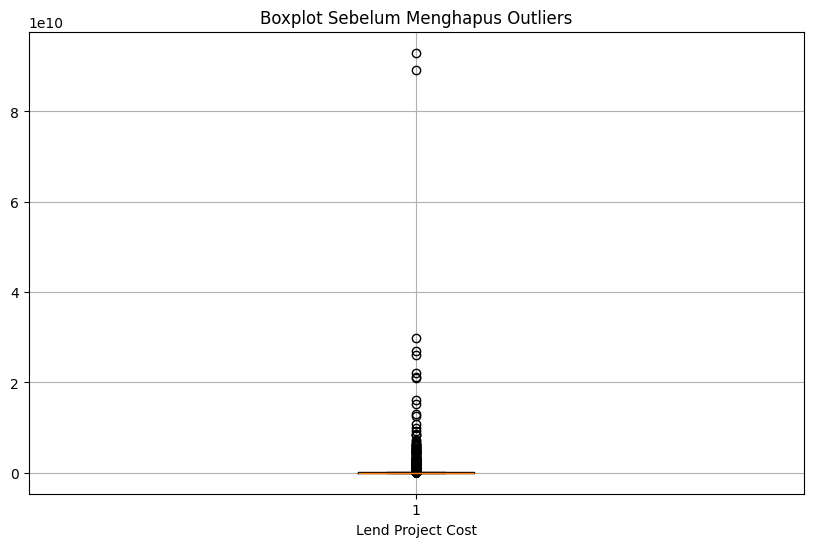

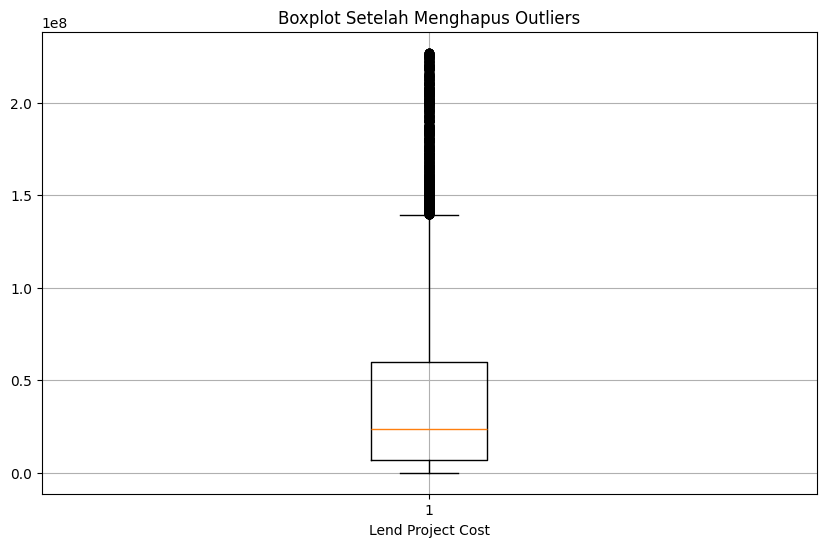

In [91]:
plt.figure(figsize=(10, 6))
plt.boxplot(project_duplicate['lendprojectcost'])
plt.title('Boxplot Sebelum Menghapus Outliers')
plt.xlabel('Lend Project Cost')
plt.grid(True)
plt.show()

Q1 = project_duplicate['lendprojectcost'].quantile(0.25)
Q3 = project_duplicate['lendprojectcost'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

project_no_outliers = project_duplicate[(project_duplicate['lendprojectcost'] >= lower_bound) & (project_duplicate['lendprojectcost'] <= upper_bound)]

plt.figure(figsize=(10, 6))
plt.boxplot(project_no_outliers['lendprojectcost'])
plt.title('Boxplot Setelah Menghapus Outliers')
plt.xlabel('Lend Project Cost')
plt.grid(True)
plt.show()


In [92]:
dummies = pd.get_dummies(project_duplicate['status'])

In [93]:
dummies_project = project_duplicate['regionname'] 
project_dummy = pd.concat([dummies_project, dummies], axis=1)

project_dummy

,regionname,0,Active,Closed,Dropped,Pipeline
0,Other,False,True,False,False,False
1,Africa,False,True,False,False,False
2,South Asia,False,True,False,False,False
3,South Asia,False,True,False,False,False
4,Africa,False,True,False,False,False
...,...,...,...,...,...,...
18243,Latin America and Caribbean,False,False,True,False,False
18244,Europe and Central Asia,False,False,True,False,False
18245,Europe and Central Asia,False,False,True,False,False
18246,Europe and Central Asia,False,False,True,False,False


In [94]:
project_dummy.to_csv('data_dummies/dummies_project_data.csv', index=False)

In [95]:
project_group = project_duplicate.groupby('countryname')['lendprojectcost'].sum().reset_index()
project_group.columns = ['countryname', 'projectcost']

print("Total rows:", project_group.shape[0])
print(project_group)


Total rows: 206
                     countryname   projectcost
0                         Africa  1.354880e+10
1                 American Samoa  2.000000e+05
2               Andean Countries  6.716000e+07
3            Antigua and Barbuda  1.000000e+07
4         Arab Republic of Egypt  4.362445e+10
..                           ...           ...
201  United Republic of Tanzania  2.992717e+10
202           West Bank and Gaza  3.686290e+09
203               Western Africa  9.441430e+09
204              Western Balkans  1.791700e+08
205                        World  8.951459e+10

[206 rows x 2 columns]


In [96]:
scaler = MinMaxScaler()

features_to_scale = ['totalamt']

project_duplicate[features_to_scale] = scaler.fit_transform(project_duplicate[features_to_scale])

project_duplicate.head()

,id,regionname,countryname,prodline,lendinginstr,lendinginstrtype,productlinetype,projectstatusdisplay,status,project_name,boardapprovaldate,board_approval_month,closingdate,lendprojectcost,ibrdcommamt,idacommamt,totalamt,grantamt,url
0,P162228,Other,World,RE,Investment Project Financing,IN,L,Active,Active,Creating a Trade in Value-Added Database for ...,2018,June,0,500000.0,0,0,0.000000,500000,http://projects.worldbank.org/P162228?lang=en
1,P163962,Africa,Democratic Republic of the Congo,PE,Investment Project Financing,IN,L,Active,Active,Productive Inclusion Project,2018,June,2023-12-31 00:00:00+00:00,200000000.0,0,200000000,0.053333,0,http://projects.worldbank.org/P163962?lang=en
2,P167672,South Asia,People's Republic of Bangladesh,PE,Investment Project Financing,IN,L,Active,Active,Additional Financing for Health Sector Support...,2018,June,0,50000000.0,0,58330000,0.015555,0,http://projects.worldbank.org/P167672?lang=en
3,P158768,South Asia,Islamic Republic of Afghanistan,PE,Investment Project Financing,IN,L,Active,Active,Public-Private Partnerships and Public Investm...,2018,June,2023-06-28 00:00:00+00:00,50000000.0,0,20000000,0.005333,0,http://projects.worldbank.org/P158768?lang=en
4,P161364,Africa,Federal Republic of Nigeria,PE,Investment Project Financing,IN,L,Active,Active,Nigeria For Women Project,2018,June,2023-05-31 00:00:00+00:00,100000000.0,0,100000000,0.026667,0,http://projects.worldbank.org/P161364?lang=en


In [97]:
project_duplicate.to_csv('data_clean/clean_projects_data.csv', index=False)

## Merge dataset population(csv, json, xml, db, mystery, api)

In [98]:
population_duplicate.update(population_json_duplicate[population_json_duplicate['Country Name'].isin(population_duplicate['Country Name'])])
population_duplicate.update(population_xml_duplicate[population_xml_duplicate['Country Name'].isin(population_duplicate['Country Name'])])
population_duplicate.update(population_data_db_duplicate[population_data_db_duplicate['Country Name'].isin(population_duplicate['Country Name'])])
population_duplicate.update(mystery_duplicate[mystery_duplicate['Country Name'].isin(population_duplicate['Country Name'])])
merge = population_duplicate.merge(data_word_bank_duplicate, on=['Country Name', 'Country Code', 'Year', 'Population'])
merge.head()

C:\Users\abdan\AppData\Local\Temp\ipykernel_14988\3630433014.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1960 1960 1960 ... 2017 2017 2017]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  population_duplicate.update(population_json_duplicate[population_json_duplicate['Country Name'].isin(population_duplicate['Country Name'])])


,Country Name,Country Code,Year,Population
0,Albania,ALB,1960,1608800.0
1,Australia,AUS,1960,10276477.0
2,Austria,AUT,1960,7047539.0
3,Belgium,BEL,1960,9153489.0
4,Bulgaria,BGR,1960,7867374.0


In [99]:
merge = pd.concat([population_duplicate, data_word_bank_duplicate], ignore_index=True)
merge

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
31972,Zimbabwe,ZWE,1964,4310332.0
31973,Zimbabwe,ZWE,1963,4177931.0
31974,Zimbabwe,ZWE,1962,4049778.0
31975,Zimbabwe,ZWE,1961,3925952.0


In [100]:
merge.drop_duplicates(subset=['Country Name', 'Country Code', 'Year'], inplace=True)

In [101]:
merge.duplicated().sum()

0

In [102]:
merge.reset_index(drop=True)

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0
...,...,...,...,...
17182,Zimbabwe,ZWE,2022,16320537.0
17183,Zimbabwe,ZWE,2021,15993524.0
17184,Zimbabwe,ZWE,2020,15669666.0
17185,Zimbabwe,ZWE,2019,15354608.0


In [103]:
# Hitung IQR
# Q1 = merge['Population'].quantile(0.25)
# Q3 = merge['Population'].quantile(0.75)
# IQR = Q3 - Q1

# # Tentukan batas bawah dan batas atas untuk mengidentifikasi outlier
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Identifikasi outlier
# outliers = merge[(merge['Population'] < lower_bound) | (merge['Population'] > upper_bound)]

# # Visualisasi boxplot dengan menandai outlier
# plt.figure(figsize=(8, 6))
# sns.boxplot(y=merge['Population'])
# plt.title('Boxplot dengan Outlier')
# plt.scatter(x=outliers.index, y=outliers['Population'], color='red', label='Outlier')
# plt.legend()
# plt.show()

In [104]:
merge.to_csv('data_combined/data_combined_population.csv', index=False)

In [105]:
merge_gdp = pd.merge(merge, gdp_duplicate, on =['Country Name', 'Country Code', 'Year'])
merge_gdp

,Country Name,Country Code,Year,Population,gdp
0,Aruba,ABW,1960,54211.0,0
1,Afghanistan,AFG,1960,8996351.0,537777811.111111
2,Angola,AGO,1960,5643182.0,0
3,Albania,ALB,1960,1608800.0,0
4,Andorra,AND,1960,13411.0,0
...,...,...,...,...,...
15161,West Bank and Gaza,PSE,1995,2474666.0,3282800000.0
15162,West Bank and Gaza,PSE,1994,2366298.0,2843300000.0
15163,West Bank and Gaza,PSE,1993,2262676.0,0
15164,West Bank and Gaza,PSE,1992,2163591.0,0


In [106]:
merge_gdp['gdp percapita'] = merge_gdp['gdp'] / merge_gdp['Population']

merge_gdp

,Country Name,Country Code,Year,Population,gdp,gdp percapita
0,Aruba,ABW,1960,54211.0,0,0.0
1,Afghanistan,AFG,1960,8996351.0,537777811.111111,59.777327
2,Angola,AGO,1960,5643182.0,0,0.0
3,Albania,ALB,1960,1608800.0,0,0.0
4,Andorra,AND,1960,13411.0,0,0.0
...,...,...,...,...,...,...
15161,West Bank and Gaza,PSE,1995,2474666.0,3282800000.0,1326.562857
15162,West Bank and Gaza,PSE,1994,2366298.0,2843300000.0,1201.581542
15163,West Bank and Gaza,PSE,1993,2262676.0,0,0.0
15164,West Bank and Gaza,PSE,1992,2163591.0,0,0.0


In [107]:
merged_data = pd.merge(rural_duplicate, data_electricity_duplicate, on=["Country Name", "Country Code", 'Year'])

In [108]:
print("Jumlah duplikasi pada merged_data:", merged_data.duplicated().sum())

# Memeriksa nilai yang hilang pada data gabungan
print("Jumlah nilai yang hilang pada merged_data:")
print(merged_data.isnull().sum())

Jumlah duplikasi pada merged_data: 0
Jumlah nilai yang hilang pada merged_data:
Country Name      0
Country Code      0
Year              0
Rural             0
Electricity     170
dtype: int64


In [109]:
mean_electricity = merged_data['Electricity'].mean()
merged_data['Electricity'] = merged_data['Electricity'].fillna(mean_electricity)


# Memeriksa kembali apakah masih ada nilai yang hilang
print("Jumlah nilai yang hilang pada merged_data setelah diisi:")
print(merged_data.isnull().sum())

Jumlah nilai yang hilang pada merged_data setelah diisi:
Country Name    0
Country Code    0
Year            0
Rural           0
Electricity     0
dtype: int64


In [110]:
merge_gdp['gdp'] = pd.to_numeric(merge_gdp['gdp'], errors='coerce')

merge_gdp['gdp'] = merge_gdp['gdp'].astype(float)
merge_gdp['gdp percapita'] = merge_gdp['gdp percapita'].astype(float)

In [111]:
data_final = pd.merge(merge_gdp, merged_data, on=["Country Name", "Country Code", "Year"])

data_final

,Country Name,Country Code,Year,Population,gdp,gdp percapita,Rural,Electricity
0,Argentina,ARG,2000,4.920508e-03,2.842038e+11,5.775903e+13,10.858000,95.099205
1,Benin,BEN,1994,7.582565e-04,1.598076e+09,2.107567e+12,63.553000,12.788180
2,Brunei Darussalam,BRN,2014,5.410435e-05,1.709834e+10,3.160253e+14,23.113000,100.000000
3,China,CHN,2008,1.759081e-01,4.598206e+12,2.613982e+13,53.461000,98.749916
4,Caribbean small states,CSS,2002,8.790438e-04,3.687262e+10,4.194628e+13,58.297774,88.621128
...,...,...,...,...,...,...,...,...
7069,West Bank and Gaza,PSE,1995,2.474666e+06,3.282800e+09,1.326563e+03,29.784000,98.291626
7070,West Bank and Gaza,PSE,1994,2.366298e+06,2.843300e+09,1.201582e+03,30.276000,98.116440
7071,West Bank and Gaza,PSE,1993,2.262676e+06,0.000000e+00,0.000000e+00,30.773000,97.932083
7072,West Bank and Gaza,PSE,1992,2.163591e+06,0.000000e+00,0.000000e+00,31.274000,97.741608


In [112]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7074 entries, 0 to 7073
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Name   7074 non-null   object 
 1   Country Code   7074 non-null   object 
 2   Year           7074 non-null   int64  
 3   Population     7074 non-null   float64
 4   gdp            7074 non-null   float64
 5   gdp percapita  7074 non-null   float64
 6   Rural          7074 non-null   float64
 7   Electricity    7074 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 442.3+ KB


In [113]:
data_final.to_csv('data_combined/data_final.csv', index=False)

## LOAD

In [114]:
short_country_names = []

for idx, row in project_duplicate.iterrows():
    found_short_country = None

    for country_short in rural_duplicate['Country Name']:
        if re.search(r'\b{}\b'.format(re.escape(country_short)), row['countryname']):
            found_short_country = country_short
            break

    short_country_names.append(found_short_country)


print(len(short_country_names))
print(short_country_names)

project_duplicate['countryname_short'] = short_country_names

18248
['World', None, 'Bangladesh', 'Afghanistan', 'Nigeria', 'Tunisia', 'Nigeria', 'Nigeria', 'Nigeria', None, None, 'Nigeria', 'Nepal', 'Nigeria', 'Kyrgyz Republic', 'Jordan', 'Myanmar', None, 'Tanzania', 'Ethiopia', 'Burkina Faso', 'Uzbekistan', 'Romania', 'Ethiopia', 'Ghana', 'Ecuador', 'Vietnam', 'China', 'Senegal', 'Grenada', 'Guyana', None, 'Indonesia', 'Kenya', 'Indonesia', 'Cambodia', 'Angola', 'India', 'China', None, 'Zambia', 'Kenya', None, 'Panama', 'Tunisia', 'Tonga', 'Pakistan', 'Pakistan', 'Bangladesh', 'Niger', 'Uganda', 'Madagascar', 'Bolivia', 'Afghanistan', 'China', 'Indonesia', None, 'Morocco', None, 'Djibouti', None, 'Maldives', 'Senegal', 'Indonesia', 'China', 'China', 'China', 'Central African Republic', 'India', None, 'Cabo Verde', "Cote d'Ivoire", 'Montenegro', 'Kyrgyz Republic', 'West Bank and Gaza', 'West Bank and Gaza', 'Ethiopia', 'Ghana', 'Haiti', 'Senegal', 'Guinea', 'Haiti', 'World', 'Samoa', 'Indonesia', None, None, 'Marshall Islands', 'Angola', 'Tunisi

In [115]:
project_duplicate[[
    'id', 'regionname', 'countryname', 'countryname_short', 'boardapprovaldate', 'lendprojectcost'
]]

,id,regionname,countryname,countryname_short,boardapprovaldate,lendprojectcost
0,P162228,Other,World,World,2018,500000.0
1,P163962,Africa,Democratic Republic of the Congo,None,2018,200000000.0
2,P167672,South Asia,People's Republic of Bangladesh,Bangladesh,2018,50000000.0
3,P158768,South Asia,Islamic Republic of Afghanistan,Afghanistan,2018,50000000.0
4,P161364,Africa,Federal Republic of Nigeria,Nigeria,2018,100000000.0
...,...,...,...,...,...,...
18243,P006578,Latin America and Caribbean,Republic of Chile,Chile,1948,13500000.0
18244,P037451,Europe and Central Asia,Grand Duchy of Luxembourg,Luxembourg,1947,12000000.0
18245,P037362,Europe and Central Asia,Kingdom of Denmark,Denmark,1947,40000000.0
18246,P037452,Europe and Central Asia,Kingdom of the Netherlands,Netherlands,1947,195000000.0


In [117]:
project_data = data_final[['Country Name', 'Year']]

# Merge dataframes
project_merge = project_duplicate.merge(
    project_data,
    how='right',
    left_on=['countryname_short', 'boardapprovaldate'],
    right_on=['Country Name', 'Year']
)[['Country Name', 'boardapprovaldate', 'lendprojectcost']]

# Sort the merged dataframe
project_merge = project_merge.sort_values(by=['Country Name', 'boardapprovaldate'])

# Display the merged dataframe
project_merge

,Country Name,boardapprovaldate,lendprojectcost
5203,Afghanistan,2002.0,4.200000e+07
5204,Afghanistan,2002.0,3.300000e+07
5205,Afghanistan,2002.0,1.500000e+07
5206,Afghanistan,2002.0,1.329000e+09
5207,Afghanistan,2002.0,1.000000e+07
...,...,...,...
7140,Zimbabwe,NaN,NaN
7690,Zimbabwe,NaN,NaN
8286,Zimbabwe,NaN,NaN
8872,Zimbabwe,NaN,NaN


In [118]:
project_merge = project_merge.fillna(0)
project_merge['boardapprovaldate'] = project_merge['boardapprovaldate'].astype(int)

project_merge

,Country Name,boardapprovaldate,lendprojectcost
5203,Afghanistan,2002,4.200000e+07
5204,Afghanistan,2002,3.300000e+07
5205,Afghanistan,2002,1.500000e+07
5206,Afghanistan,2002,1.329000e+09
5207,Afghanistan,2002,1.000000e+07
...,...,...,...
7140,Zimbabwe,0,0.000000e+00
7690,Zimbabwe,0,0.000000e+00
8286,Zimbabwe,0,0.000000e+00
8872,Zimbabwe,0,0.000000e+00


In [119]:
# Memilih baris dengan boardapprovaldate dalam rentang tahun 1960-2023
project_merge = project_merge.loc[(project_merge['boardapprovaldate'] >= 1960) & (project_merge['boardapprovaldate'] <= 2023)]

# Reset indeks DataFrame
project_merge.reset_index(drop=True, inplace=True)
project_merge

,Country Name,boardapprovaldate,lendprojectcost
0,Afghanistan,2002,4.200000e+07
1,Afghanistan,2002,3.300000e+07
2,Afghanistan,2002,1.500000e+07
3,Afghanistan,2002,1.329000e+09
4,Afghanistan,2002,1.000000e+07
...,...,...,...
9134,Zimbabwe,2015,1.500000e+07
9135,Zimbabwe,2015,2.000000e+06
9136,Zimbabwe,2016,1.900000e+06
9137,Zimbabwe,2016,2.080000e+07


In [120]:
load = project_merge.merge(
    data_final,
    how='right',
    left_on=['Country Name', 'boardapprovaldate'],
    right_on=['Country Name', 'Year'])[['Country Name', 'Country Code', 'Year', 'gdp', 'Population', 'gdp percapita',
                       'Rural', 'Electricity', 'lendprojectcost']]

load

,Country Name,Country Code,Year,gdp,Population,gdp percapita,Rural,Electricity,lendprojectcost
0,Argentina,ARG,2000,2.842038e+11,4.920508e-03,5.775903e+13,10.858,95.099205,NaN
1,Benin,BEN,1994,1.598076e+09,7.582565e-04,2.107567e+12,63.553,12.788180,15000000.0
2,Benin,BEN,1994,1.598076e+09,7.582565e-04,2.107567e+12,63.553,12.788180,22900000.0
3,Benin,BEN,1994,1.598076e+09,7.582565e-04,2.107567e+12,63.553,12.788180,19100000.0
4,Brunei Darussalam,BRN,2014,1.709834e+10,5.410435e-05,3.160253e+14,23.113,100.000000,NaN
...,...,...,...,...,...,...,...,...,...
13840,West Bank and Gaza,PSE,1995,3.282800e+09,2.474666e+06,1.326563e+03,29.784,98.291626,20000000.0
13841,West Bank and Gaza,PSE,1994,2.843300e+09,2.366298e+06,1.201582e+03,30.276,98.116440,93500000.0
13842,West Bank and Gaza,PSE,1993,0.000000e+00,2.262676e+06,0.000000e+00,30.773,97.932083,NaN
13843,West Bank and Gaza,PSE,1992,0.000000e+00,2.163591e+06,0.000000e+00,31.274,97.741608,NaN


In [121]:
# Menjumlahkan lendprojectcost berdasarkan kolom yang duplicated
load = load.groupby(['Country Name', 'Country Code', 'Year', 'Population', 'gdp',
                             'gdp percapita', 'Rural', 'Electricity']
                            )['lendprojectcost'].sum().reset_index()

# Menghapus baris yang duplikat setelah dijumlahkan, hanya menyisakan satu baris
load.drop_duplicates(subset=['Country Name', 'Country Code', 'Year'], keep='first', inplace=True)

load

,Country Name,Country Code,Year,Population,gdp,gdp percapita,Rural,Electricity,lendprojectcost
0,Afghanistan,AFG,1990,12249114.0,0.000000e+00,0.000000,81.684,0.010000,0.0
1,Afghanistan,AFG,1991,12993657.0,0.000000e+00,0.000000,81.403,0.010000,0.0
2,Afghanistan,AFG,1992,13981231.0,0.000000e+00,0.000000,81.118,0.010000,0.0
3,Afghanistan,AFG,1993,15095099.0,0.000000e+00,0.000000,80.830,0.010000,0.0
4,Afghanistan,AFG,1994,16172719.0,0.000000e+00,0.000000,80.538,0.010000,0.0
...,...,...,...,...,...,...,...,...,...
7069,Zimbabwe,ZWE,2012,14710826.0,1.424249e+10,968.163875,67.166,36.728878,0.0
7070,Zimbabwe,ZWE,2013,15054506.0,1.545177e+10,1026.388292,67.346,37.076813,21000000.0
7071,Zimbabwe,ZWE,2014,15411675.0,1.589105e+10,1031.104614,67.499,32.300000,31200000.0
7072,Zimbabwe,ZWE,2015,15777451.0,1.630467e+10,1033.415841,67.624,33.700000,17000000.0


In [122]:
load.to_csv('data_combined/data_load.csv', index=False)

## LOAD TO FIREBASE

In [123]:
cred = credentials.Certificate(r"C:\Users\abdan\Documents\GitHub\DE_Mini-Project\mini-projects.json")
firebase_admin.initialize_app(cred, {"storageBucket": "mini-project-f9e27.appspot.com"})
bucket = storage.bucket()

blob_name = 'data_load.csv'  
blob = bucket.blob(blob_name) 

blob.upload_from_filename("data_combined/data_load.csv")

## Outliers and Scalling Feature

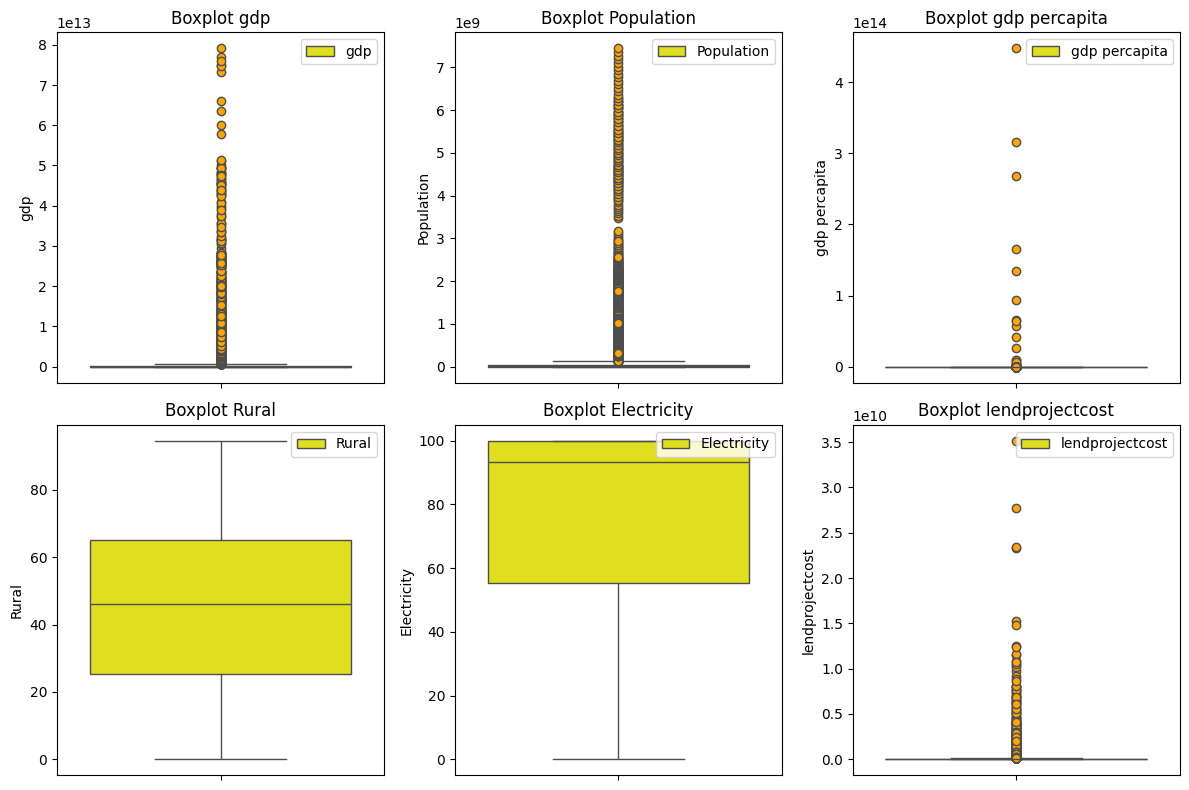

In [124]:
columns = ['gdp', 'Population', 'gdp percapita', 'Rural', 'Electricity', 'lendprojectcost']

plt.figure(figsize=(12, 8))

for i, column in enumerate(columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=load, y=column, color='yellow', flierprops=dict(marker='o', markerfacecolor='orange'))
    plt.title(f'Boxplot {column}')
    plt.xticks(rotation=45)
    plt.legend([column], loc='upper right')  

plt.tight_layout()
plt.show()


In [125]:
scaler = MinMaxScaler()

features_to_scale = ['Population', 'gdp', 'gdp percapita', 'Rural', 'Electricity', 'lendprojectcost']

load[features_to_scale] = scaler.fit_transform(load[features_to_scale])

load.head()

,Country Name,Country Code,Year,Population,gdp,gdp percapita,Rural,Electricity,lendprojectcost
0,Afghanistan,AFG,1990,0.001645,0.0,0.0,0.863613,0.0001,0.0
1,Afghanistan,AFG,1991,0.001745,0.0,0.0,0.860642,0.0001,0.0
2,Afghanistan,AFG,1992,0.001878,0.0,0.0,0.857629,0.0001,0.0
3,Afghanistan,AFG,1993,0.002028,0.0,0.0,0.854584,0.0001,0.0
4,Afghanistan,AFG,1994,0.002173,0.0,0.0,0.851497,0.0001,0.0


## Visualisasi

In [137]:
data_load = pd.read_csv("data_combined/data_load.csv")

# Tampilkan lima baris pertama dari dataset
print(data_load.head())

  Country Name Country Code  Year  Population  gdp  gdp percapita   Rural  \
0  Afghanistan          AFG  1990  12249114.0  0.0            0.0  81.684   
1  Afghanistan          AFG  1991  12993657.0  0.0            0.0  81.403   
2  Afghanistan          AFG  1992  13981231.0  0.0            0.0  81.118   
3  Afghanistan          AFG  1993  15095099.0  0.0            0.0  80.830   
4  Afghanistan          AFG  1994  16172719.0  0.0            0.0  80.538   

   Electricity  lendprojectcost  
0         0.01              0.0  
1         0.01              0.0  
2         0.01              0.0  
3         0.01              0.0  
4         0.01              0.0  


In [163]:
# Visualisasi 1: Tren GDP per Kapita dari Berbagai Negara dari Tahun ke Tahun
vis1 = px.line(data_load, x='Year', y='gdp percapita', color='Country Name', title='Tren GDP per Kapita dari Berbagai Negara')

# Visualisasi 2: Peta Choropleth untuk GDP
vis2 = px.choropleth(data_load, locations='Country Code', color='gdp', hover_name='Country Name', title='Distribusi GDP di Berbagai Negara')

# Visualisasi 3: GDP per Kapita vs Jumlah Penduduk
vis3 = px.scatter(data_load, x='gdp percapita', y='Population', color='Country Name', title='Hubungan antara GDP per Kapita dan Jumlah Penduduk')

vis1.show()
vis2.show()
vis3.show()

In [162]:
vis4 = px.line(data_load, x='Year', y=['Rural', 'Electricity'], 
              title='Tren Rural dan Electricity')

# Menambahkan label sumbu-y
vis4.update_yaxes(title_text="Persentase")

# Menambahkan label legenda
vis4.update_traces(name='Persentase Populasi Rural', selector=dict(name='Rural'))
vis4.update_traces(name='Persentase Penduduk yang Memiliki Akses Listrik', selector=dict(name='Electricity'))

# Menampilkan visualisasi
vis4.show()